In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
# Prices
ticker = "SPY"
start_date = "2015-01-01"
prices = yf.download(ticker, start=start_date, auto_adjust=True)["Close"].dropna()
print("PRICES HEAD:")
print(prices.head())

[*********************100%***********************]  1 of 1 completed

PRICES HEAD:
Ticker             SPY
Date                  
2015-01-02  171.093674
2015-01-05  168.003815
2015-01-06  166.421371
2015-01-07  168.495209
2015-01-08  171.485107


In [3]:
# Returns
returns = prices.pct_change().dropna()
print("\nRETURNS HEAD:")
print (returns.head())


RETURNS HEAD:
Ticker           SPY
Date                
2015-01-05 -0.018059
2015-01-06 -0.009419
2015-01-07  0.012461
2015-01-08  0.017745
2015-01-09 -0.008013


In [4]:
# Rolling Volatility
window = 60
rolling_daily_vol = returns.rolling(window).std()
rolling_annualized_vol = rolling_daily_vol * (252 ** 0.5)
print("\nROLLING ANNUALIZED VOL HEAD:")
print(rolling_annualized_vol.head(80))


ROLLING ANNUALIZED VOL HEAD:
Ticker           SPY
Date                
2015-01-05       NaN
2015-01-06       NaN
2015-01-07       NaN
2015-01-08       NaN
2015-01-09       NaN
...              ...
2015-04-23  0.118147
2015-04-24  0.114726
2015-04-27  0.113914
2015-04-28  0.110533
2015-04-29  0.108474

[80 rows x 1 columns]


In [5]:
target_vol = 0.2 # annualized target volatility of 15%

In [6]:
# Exposure Calculation
exposure = target_vol / rolling_annualized_vol 
cap = 3.0 # maximum exposure cap
exposure = exposure.clip(upper=cap)
print("\nEXPOSURE HEAD:")
print(exposure.head(80))


EXPOSURE HEAD:
Ticker           SPY
Date                
2015-01-05       NaN
2015-01-06       NaN
2015-01-07       NaN
2015-01-08       NaN
2015-01-09       NaN
...              ...
2015-04-23  1.692803
2015-04-24  1.743281
2015-04-27  1.755710
2015-04-28  1.809408
2015-04-29  1.843766

[80 rows x 1 columns]


In [7]:
# Calculate Scaled Returns
scaled_returns = exposure.shift(1)*returns # shift by 1 to avoid look-ahead bias 
# I dont know the exposure for the current day when calculating today's return 
# so i use yesterday's exposure to scale today's return.
# Its like a backtest and i calculate my returns if i had invested according to yesterday's exposure.
print("\nSCALED RETURNS HEAD:")
print(scaled_returns.head(80))


SCALED RETURNS HEAD:
Ticker           SPY
Date                
2015-01-05       NaN
2015-01-06       NaN
2015-01-07       NaN
2015-01-08       NaN
2015-01-09       NaN
...              ...
2015-04-23  0.004142
2015-04-24  0.003928
2015-04-27 -0.007248
2015-04-28  0.005581
2015-04-29 -0.007445

[80 rows x 1 columns]


In [8]:
# Cumulative Returns
scaled_returns_new = scaled_returns.fillna(0) # fill NaN values with 0 for cumulative return calculation
strategy_portfolio = (1 + scaled_returns_new).cumprod()
benchmark_portfolio = (1+returns).cumprod()
strategy_profit = strategy_portfolio - 1
benchmark_profit = benchmark_portfolio - 1
print("\nSTRATEGY PORTFOLIO TAIL:")
print(strategy_portfolio.tail(10))
print("\nBENCHMARK PORTFOLIO TAIL:")
print(benchmark_portfolio.tail(10))
print("\n Final Strategy Portfolio Value:", strategy_portfolio.iloc[-1])
print(" Final Benchmark Portfolio Value :", benchmark_portfolio.iloc[-1])
print("\n Strategy total return (%) :", (strategy_portfolio.iloc[-1]-1)*100)
print("\n Benchmark total return (%)  :", (benchmark_portfolio.iloc[-1]-1)*100)


STRATEGY PORTFOLIO TAIL:
Ticker           SPY
Date                
2025-11-06  5.324617
2025-11-07  5.334278
2025-11-10  5.487693
2025-11-11  5.510026
2025-11-12  5.515475
2025-11-13  5.351591
2025-11-14  5.350097
2025-11-17  5.264760
2025-11-18  5.187733
2025-11-19  5.205647

BENCHMARK PORTFOLIO TAIL:
Ticker           SPY
Date                
2025-11-06  3.917795
2025-11-07  3.921653
2025-11-10  3.982847
2025-11-11  3.991965
2025-11-12  3.994186
2025-11-13  3.927907
2025-11-14  3.927264
2025-11-17  3.890676
2025-11-18  3.858004
2025-11-19  3.865719

 Final Strategy Portfolio Value: Ticker
SPY    5.205647
Name: 2025-11-19 00:00:00, dtype: float64
 Final Benchmark Portfolio Value : Ticker
SPY    3.865719
Name: 2025-11-19 00:00:00, dtype: float64

 Strategy total return (%) : Ticker
SPY    420.564684
Name: 2025-11-19 00:00:00, dtype: float64

 Benchmark total return (%)  : Ticker
SPY    286.571876
Name: 2025-11-19 00:00:00, dtype: float64


In [9]:
# Computation of annualized Return 
strategy_portfolio_final = strategy_portfolio.iloc[-1] 
days = len(strategy_portfolio)
annulized_return_strategy = (strategy_portfolio_final)**(252/days) - 1
print("\n Annualized Return of Strategy (%) :", annulized_return_strategy*100)


 Annualized Return of Strategy (%) : Ticker
SPY    16.403752
Name: 2025-11-19 00:00:00, dtype: float64


In [10]:
# Computation of sharpe ratio
strategy_annualized_vol = scaled_returns_new.std()*(252**0.5) # annualized volatility of strategy
sharpe_ratio_strategy = (annulized_return_strategy)/(strategy_annualized_vol)
print("\n Sharpe Ratio of Strategy :", sharpe_ratio_strategy) # Αssuming risk-free rate is 0


 Sharpe Ratio of Strategy : Ticker
SPY    0.756116
dtype: float64



 Maximum Drawdown of Strategy (%) : Ticker
SPY   -218.403458
dtype: float64


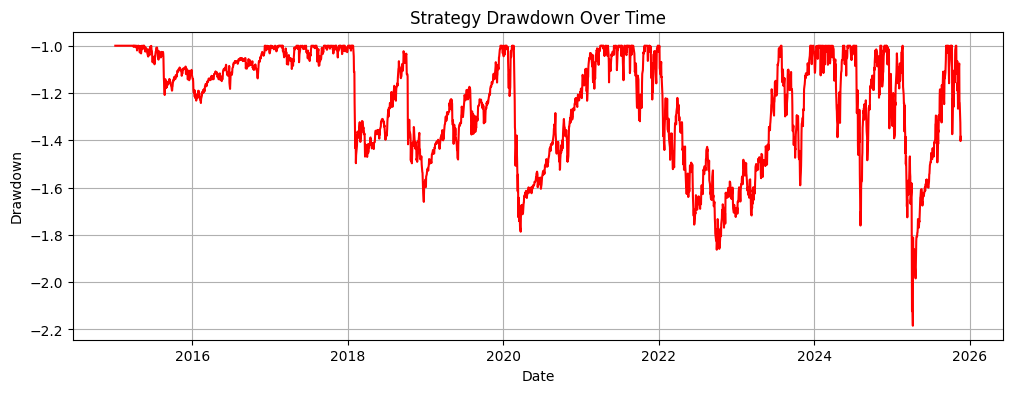

In [11]:
# Maximum Drawdown Calculation
runningmax = strategy_portfolio.cummax()
drawdown = (strategy_portfolio - runningmax) - 1
max_drawdown = drawdown.min()
print("\n Maximum Drawdown of Strategy (%) :", max_drawdown*100)
# Plot the drawdown
plt.figure(figsize=(12, 4))
plt.plot(drawdown, color="red")
plt.title("Strategy Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()

Plotting the Results

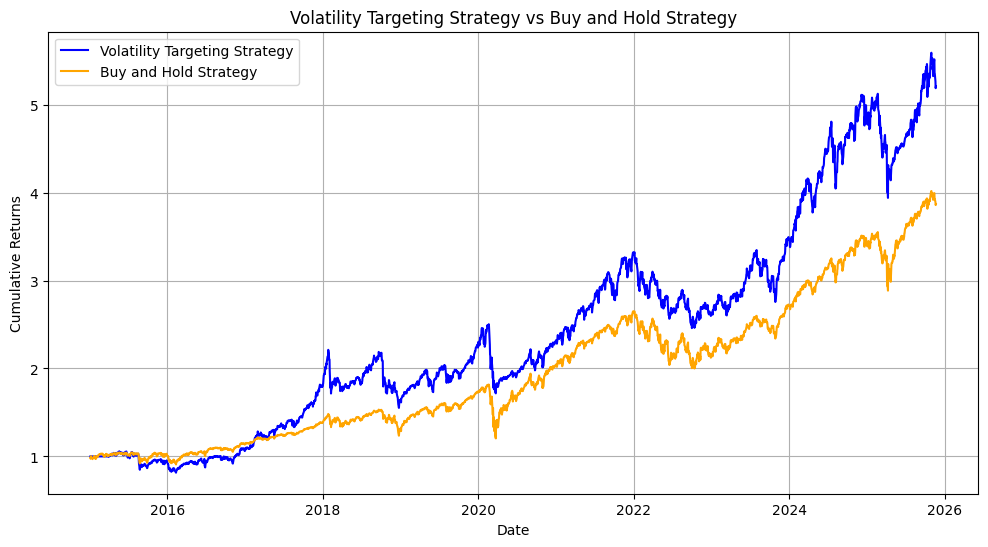

In [12]:
# Strategy vs Benchmark
plt.figure(figsize=(12, 6))
plt.plot(strategy_portfolio, label="Volatility Targeting Strategy", color="blue")
plt.plot(benchmark_portfolio, label="Buy and Hold Strategy", color="orange")
plt.title("Volatility Targeting Strategy vs Buy and Hold Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

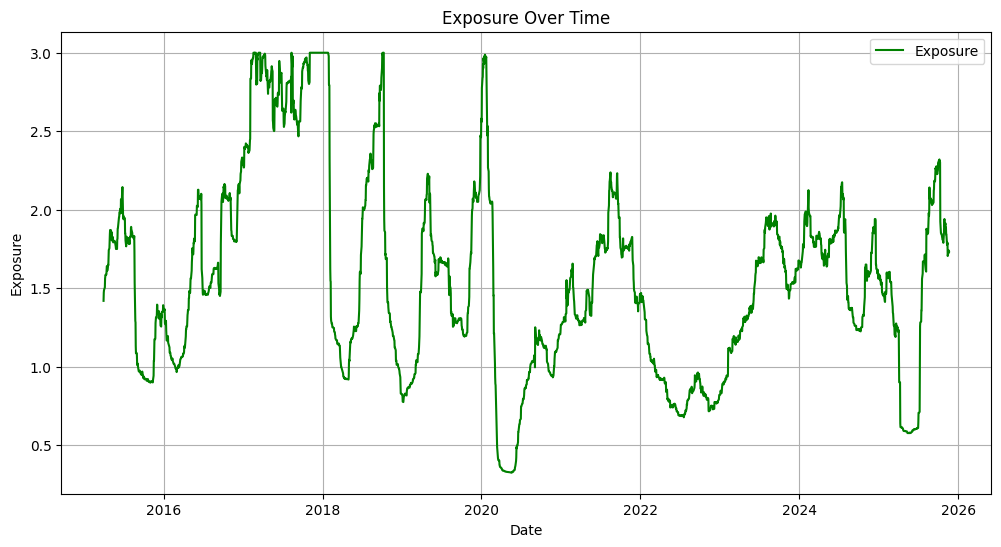

In [13]:
# Exposure Over Time
plt.figure(figsize=(12, 6))
plt.plot(exposure, label="Exposure", color="green")
plt.title("Exposure Over Time")
plt.xlabel("Date")
plt.ylabel("Exposure")
plt.legend()
plt.grid(True)
plt.show()

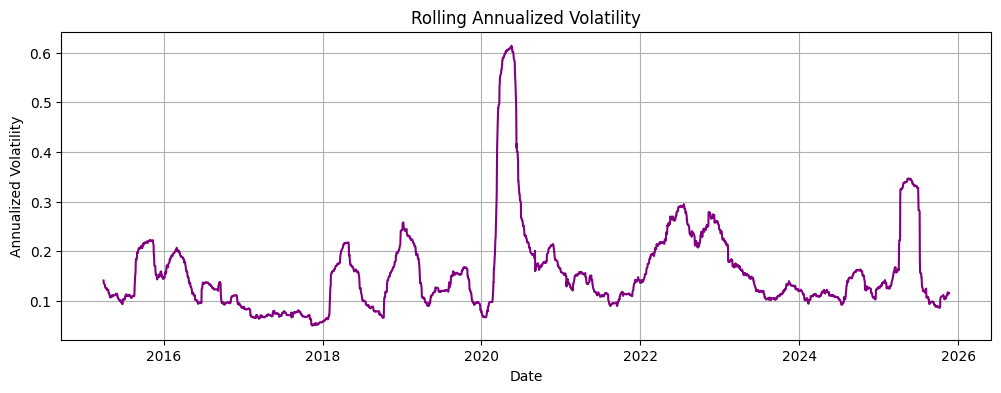

In [14]:
# Rolling Annualized Volatility
plt.figure(figsize=(12, 4))
plt.plot(rolling_annualized_vol, color="purple")
plt.title("Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.grid(True)
plt.show()